# COSC 4P96 Assignment 1: Supervised to Semi-Supervised Learning
Elias Switzer, 7419997

Set Parameters

In [ ]:
#Random seed
seed = 0

# Data processing and augmentation
scaling_min = 0 # set the min for min-max scaling
scaling_max = 1 # set the max for min-max scaling
p_horizonal_flip = 0.5 # probability of a horizontal flip
std_noise = 0.1 # standard deviation for distribution to sample added noise from

# Data splitting
train_split = 0.8
val_split = 0.1
labeled_split = 0.2 # percentage of training data to be labeled
initial_train_split = 0.75 # percentage of labeled data to train supervised network with

init_training_batch_size = 64 # for mini-batch training
init_validation_batch_size = 64

# Model parameters
epochs = 30 # number of epochs for training
lr = 0.01 # learning rate: experiment with values in [0.001, 0.1]
momentum = 0.9 # momentum value: experiment with values in [0.5, 0.99]
init_type = "he" # weight initialization: "random_uniform", "random_normal", or "he"
overfitting_window = 5 # number of previous epochs to check for overfitting
lambda_l2 = 1e-4 # controls the lambda in weight decay regularization
p_dropout = 0.5 # controls the dropout probability (need to implement properly with model parameters)

# need to add if None is specified then don't use that technique


Imports and random seeds

In [2]:
import torch
torch.manual_seed(seed)

from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

Device configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # will run on GPU if available
print("Using device: ", device)

Using device:  cuda


Load CIFAR-10 dataset

In [4]:
transform = v2.Compose([
    v2.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Apply the data transformations

In [5]:
from data_prep import compute_mean_std, compute_min_max, MinMaxScaling

data_mean, data_std = compute_mean_std(dataset)
data_min, data_max = compute_min_max(dataset)

dataset.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std), # Apply z-score normalization
    MinMaxScaling(data_min, data_max, scaling_min, scaling_max), # Apply min-max scaling to [0,1]

    v2.RandomHorizontalFlip(p=p_horizonal_flip),
    v2.RandomCrop((32,32)),
    v2.GaussianNoise(mean=0, sigma=std_noise),
    v2.ColorJitter()
])

Split data

In [7]:
# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(seed)

# Split into training, validation and testing data
train_set, val_set, test_set = random_split(dataset, [train_split, val_split, 1-train_split-val_split], generator=generator)

# Split into labeled and unlabeled for semi-supervised setup
labeled_training_set, unlabeled_training_set = random_split(train_set, [labeled_split, 1-labeled_split], generator=generator)

# Split into initial training and validation (from the labeled data)
initial_training_set, initial_validation_set = random_split(labeled_training_set, [initial_train_split, 1-initial_train_split], generator=generator)

Preview the data

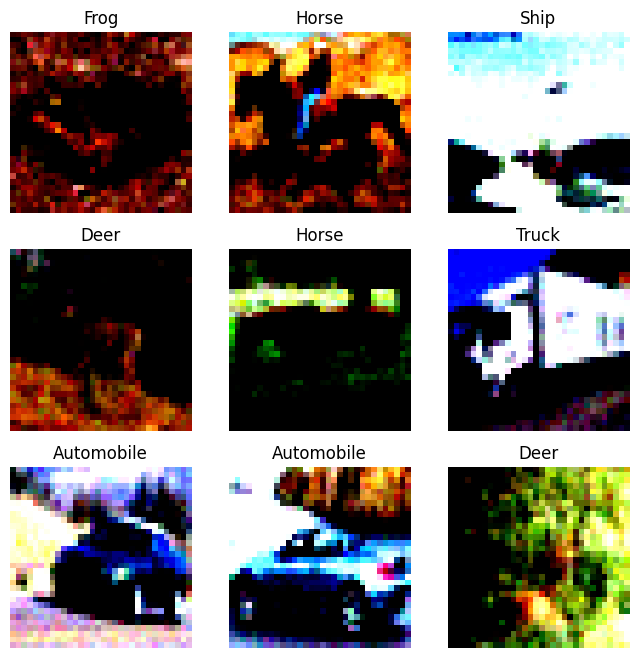

In [6]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

Create data loaders

In [8]:
initial_train_loader = DataLoader(initial_training_set, batch_size=init_training_batch_size, shuffle=True) # specifying batch size > 1 ensures mini-batch gradient descent is used
initial_val_loader = DataLoader(initial_validation_set, batch_size=init_validation_batch_size)
test_loader = DataLoader(test_set, batch_size=64)

Configure supervised neural network, weight initialization, optimizer and loss function

In [9]:
from model_supervised import SupervisedNetwork, init_weights
import torch.nn as nn
import torch.optim as optim

model = SupervisedNetwork()
model.apply(lambda m: init_weights(m, type=init_type))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Train and validate baseline supervised neural network

In [10]:
from train_test import train
metrics = train(model, device, epochs, initial_train_loader, initial_val_loader, optimizer, criterion, overfitting_window, lambda_l2)

Epoch [1/30] | Train Loss: 2.3074, Train Accuracy: 0.1908 |  Val Loss: 2.1715, Val Accuracy: 0.2770
Epoch [2/30] | Train Loss: 2.2121, Train Accuracy: 0.2988 |  Val Loss: 2.1002, Val Accuracy: 0.3560
Epoch [3/30] | Train Loss: 2.1692, Train Accuracy: 0.3473 |  Val Loss: 2.0754, Val Accuracy: 0.3855
Epoch [4/30] | Train Loss: 2.1444, Train Accuracy: 0.3706 |  Val Loss: 2.0607, Val Accuracy: 0.4030
Epoch [5/30] | Train Loss: 2.1195, Train Accuracy: 0.3988 |  Val Loss: 2.0282, Val Accuracy: 0.4365
Epoch [6/30] | Train Loss: 2.1059, Train Accuracy: 0.4136 |  Val Loss: 2.0271, Val Accuracy: 0.4315
Epoch [7/30] | Train Loss: 2.0870, Train Accuracy: 0.4276 |  Val Loss: 2.0209, Val Accuracy: 0.4415
Epoch [8/30] | Train Loss: 2.0791, Train Accuracy: 0.4419 |  Val Loss: 2.0147, Val Accuracy: 0.4440
Epoch [9/30] | Train Loss: 2.0690, Train Accuracy: 0.4458 |  Val Loss: 2.0060, Val Accuracy: 0.4500
Epoch [10/30] | Train Loss: 2.0556, Train Accuracy: 0.4624 |  Val Loss: 1.9919, Val Accuracy: 0.4640

Test model

In [11]:
from train_test import test
average_test_loss, test_acc = test(model, device, test_loader, criterion)

Average Test Loss: 2.0165, Test Accuracy: 0.4369


Visualize training and validation loss

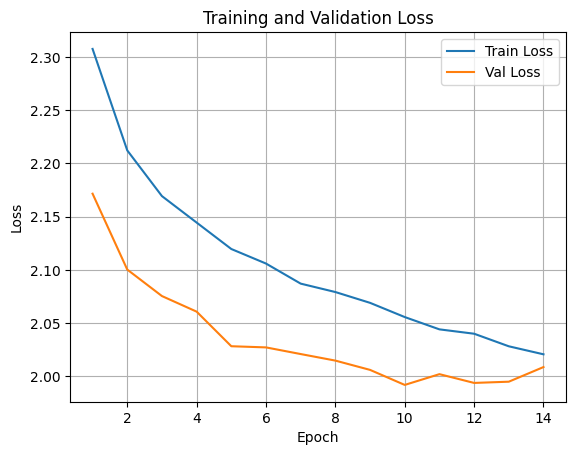

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(metrics['train_loss']) + 1)

plt.figure()
plt.plot(epochs, metrics["train_loss"], label="Train Loss")
plt.plot(epochs, metrics["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

Visualize training and validation accuracy

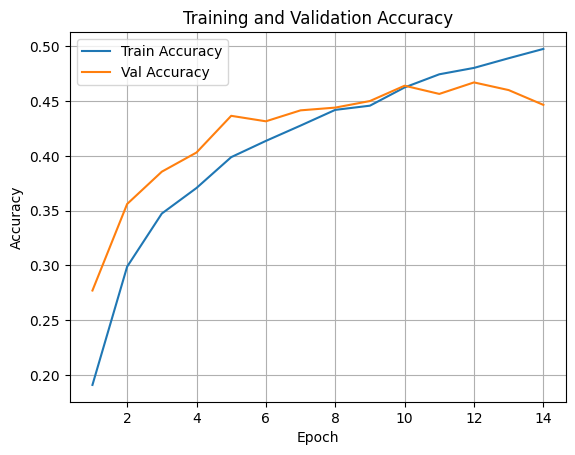

In [13]:
plt.figure()
plt.plot(epochs, metrics["train_acc"], label="Train Accuracy")
plt.plot(epochs, metrics["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)